This is dataset of colored shapes.

<img src="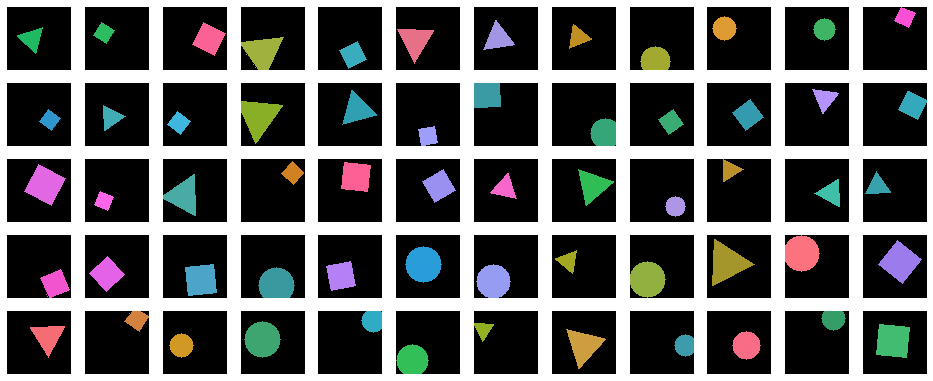
">

Each image has resolution $64 \times 64$. Across the dataset, there are three underlying varying factors:

+ Shape 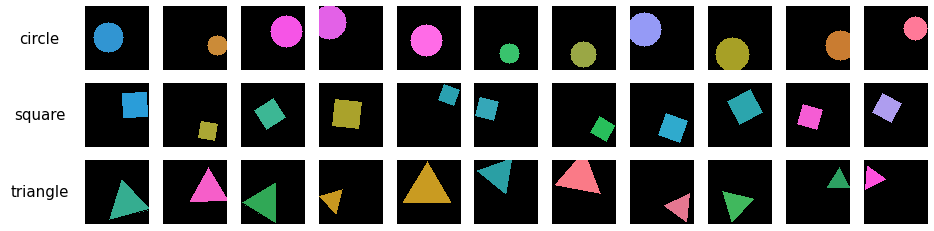
+ Color 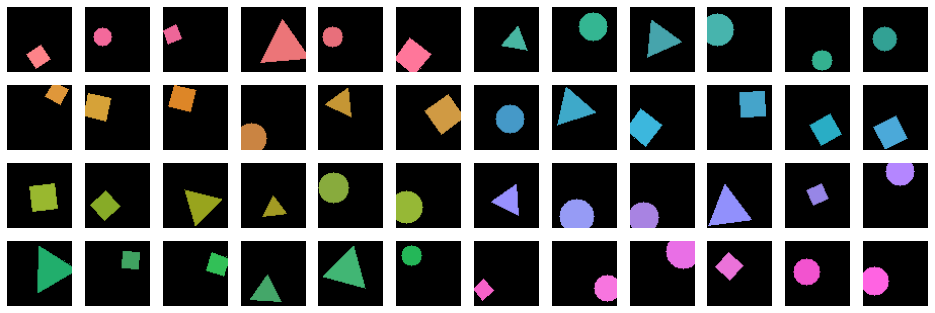
+ Location <img src="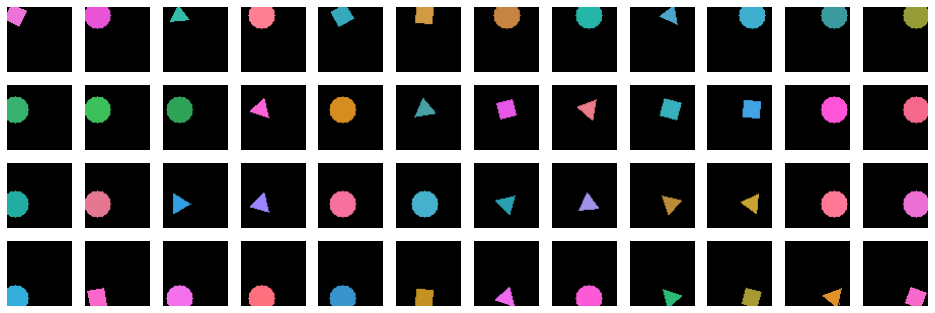
">

Without using any labelled information about these factors, I will train autoencoders and contrastive encoders on this dataset, and evaluate the resulting latent spaces via nearest neighbor classification to test the encoders learn to capture these factors. 

In [ ]:
from typing import *
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import contextlib

import torch
from torch import nn, optim
from torch.nn import functional as F

device = torch.device('cuda:0')
assert torch.cuda.is_available()

import torchvision
from IPython import display
from PIL import Image

from tqdm.auto import tqdm

!gdown 1VWqzW3GiFEnQhYhdoxDhHWUcdIuWLf3m

Downloading...
From: https://drive.google.com/uc?id=1VWqzW3GiFEnQhYhdoxDhHWUcdIuWLf3m
To: /content/shapes_dataset_6s898.npy
100% 787M/787M [00:02<00:00, 291MB/s]


# Dataset

In [ ]:
# load data

data = np.load('/content/shapes_dataset_6s898.npy', allow_pickle=True).item()
train_indices, val_indices = torch.arange(data['imgs'].shape[0]).split([64000 - 24000, 24000])


class Dataset:
    r'''
    Our dataset object for loading shapes dataset.
    '''

    def __init__(self, split: str, transform=None, num_samples: int = 1):
        r'''
        split (str): Whether to load training of validation images. Should be 'train' or 'val'.
        transform: Transformations on raw data, e.g., augmentations and/or normalization.
                   `to_tensor` and normalization is called automatically. 
                   No need to explicitly pass in `ToTensor()` or `Normalize()`.
        num_samples (int):Number of transformed versions to return for each sample. 
                           For autoencoder, this is 1. For contrastive, this is 2.
        '''
        self.split = split
        if split == 'train':
            self.indices = train_indices 
        else:
            assert split == 'val'
            self.indices = val_indices 
        self.num_samples = num_samples
        if transform is None:
            transform = lambda x: x
        self.transform = transform

    def get_augs(self, idx, num_samples):
        img = torchvision.transforms.functional.to_tensor(data['imgs'][self.indices[idx]])
        return tuple(self.transform(img).clamp(0, 1) for _ in range(num_samples))

    def __getitem__(self, idx):
        r'''
        Fetech the data at index `idx`
        '''
        return tuple(tensor.sub(0.5).div(0.5) for tensor in self.get_augs(idx, num_samples=self.num_samples))

    def visualize(self, idx, num_samples=None):
        r'''
        Visualize the image at index `idx` for `num_samples` times (default to `self.num_samples`). 

        These samples will be different if `self.transform` is random.
        '''
        if num_samples is None:
            num_samples = self.num_samples
        f, axs = plt.subplots(1, num_samples, figsize=(1.2 * num_samples, 1.4))
        if num_samples == 1:
            axs = [axs]
        else:
            axs = axs.reshape(-1)
        for ax, tensor in zip(axs, self.get_augs(idx, num_samples)):
            ax.axis('off')
            ax.imshow(tensor.permute(1, 2, 0))
        title = f'{self.split} dataset[{idx}]'
        if num_samples > 1:
            title += f'  ({num_samples} samples)'
        f.suptitle(title, fontsize=17, y=0.98)
        f.tight_layout(rect=[0, 0.03, 1, 0.9])
        return f

    def __len__(self):
        return self.indices.shape[0]

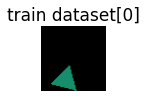

In [ ]:
# Visualize

dataset = Dataset('train')
_ = dataset.visualize(0)

# Network architectures

In [ ]:
# encoder architecture
class Encoder(nn.Module):
    def __init__(self, latent_dim, normalize: bool = False):
        r'''
        latent_dim (int): Dimension of latent space
        normalize (bool): Whether to restrict the output latent onto the unit hypersphere
        '''
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1) # 64x64 --> 32x32
        self.conv2 = nn.Conv2d(32, 32*2, 4, stride=2, padding=1) # 32x32 --> 16x16
        self.conv3 = nn.Conv2d(32*2, 32*4, 4, stride=2, padding=1) # 16x16 --> 8x8
        self.conv4 = nn.Conv2d(32*4, 32*8, 4, stride=2, padding=1) # 8x8 --> 4x4
        self.conv5 = nn.Conv2d(32*8, 32*16, 4, stride=2, padding=1) # 4x4 --> 2x2
        self.conv6 = nn.Conv2d(32*16, latent_dim, 4, stride=2, padding=1) # 2x2 --> 1x1
        self.fc = nn.Linear(latent_dim, latent_dim) 

        self.nonlinearity = nn.ReLU()
        self.normalize = normalize
            
    def forward(self, x):
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.nonlinearity(self.conv5(x))
        x = self.nonlinearity(self.conv6(x).flatten(1))
        x = self.fc(x)
        if self.normalize:
            x = F.normalize(x)
        return x

    def extra_repr(self):
        return f'normalize={self.normalize}'


# decoder architecture
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        r'''
        latent_dim (int): Dimension of latent space
        '''
        super(Decoder, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_dim, 32*16, 4, stride=2, padding=1) # 1x1 --> 2x2
        self.conv2 = nn.ConvTranspose2d(32*16, 32*8, 4, stride=2, padding=1) # 2x2 --> 4x4
        self.conv3 = nn.ConvTranspose2d(32*8, 32*4, 4, stride=2, padding=1) # 4x4 --> 8x8
        self.conv4 = nn.ConvTranspose2d(32*4, 32*2, 4, stride=2, padding=1) # 8x8 --> 16x16
        self.conv5 = nn.ConvTranspose2d(32*2, 32, 4, stride=2, padding=1) # 16x16 --> 32x32
        self.conv6 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1) # 32x32 --> 64x64
        self.nonlinearity = nn.ReLU()
            
    def forward(self, z):
        z = z[..., None, None]  # make it convolution-friendly

        x = self.nonlinearity(self.conv1(z))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.nonlinearity(self.conv5(x))
        return self.conv6(x)

# Nearest Neighbor Visualization

`nn_visualize` function is to visualizes an encoder's embedding by plotting the nearest neighbors.  In particular, for an  input image, I plot the images that are closest to them in the feature space. By looking at them, we can understand what images the encoder considers similar (i.e., having low feature space distance).

In [ ]:
@torch.no_grad()
def get_features(dataset: Dataset, encoder: Encoder, firstk: Optional[int] = None):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, pin_memory=True)
    n = 0
    features = []
    for batches in dataloader:
        batch = batches[0]
        features.append(encoder(batch.to(device)))
        n += batch.shape[0]
        if firstk is not None and n >= firstk:
            break
    features = torch.cat(features)
    if firstk is not None:
        features = features[:firstk]
    return features

@torch.no_grad()
def nn_visualize(dataset: Dataset, encoder: Encoder, num_nn: int = 10, desc: str = ''):
    r'''
    For a given `dataset` object, visualize `encoder` by nearest neighbors.

    In particular, the function takes `8` samples from `dataset`, computes
    their `num_nn` nearest neighbor samples (w.r.t. l2 embedding distance induced by
    `encoder`), and produces a plot.

    `desc` is a string description that is used to set the title of the plot.
    '''
    all_features = get_features(dataset, encoder, firstk=24000)
    source_feat = all_features[:8]
    dists = (source_feat[:, None] - all_features).pow(2).sum(-1)
    knns = torch.topk(dists, num_nn, dim=-1, largest=False).indices.cpu()

    nrow = knns.shape[0]
    ncol = num_nn + 2
    f, axes = plt.subplots(nrow, ncol, figsize=(ncol * 1, nrow * 1.1 + 1))
    for ax in axes.reshape(-1):
        ax.axis('off')

    axes[0, 0].set_title('Input Image', fontsize=15)

    for ax, imidx in zip(axes[:, 0], dataset.indices):
        ax.imshow(data['imgs'][imidx])

    for j in range(2, ncol):
        axes[0, j].set_title(f'NN {1 +j-2}', fontsize=15)

    for i in range(nrow):
        for j in range(2, ncol):
            axes[i, j].imshow(data['imgs'][dataset.indices[knns[i, j - 2]]])

    f.suptitle(f'{desc} Nesrest Neighbors (NNs) on {dataset.split.capitalize()} Set \n(near -> far, NN 1 is closest)', fontsize=20, y=0.98)
    f.tight_layout(rect=[0, 0.03, 1, 0.9])
    f.subplots_adjust(wspace=0.05, hspace=0.1)
    f.show()

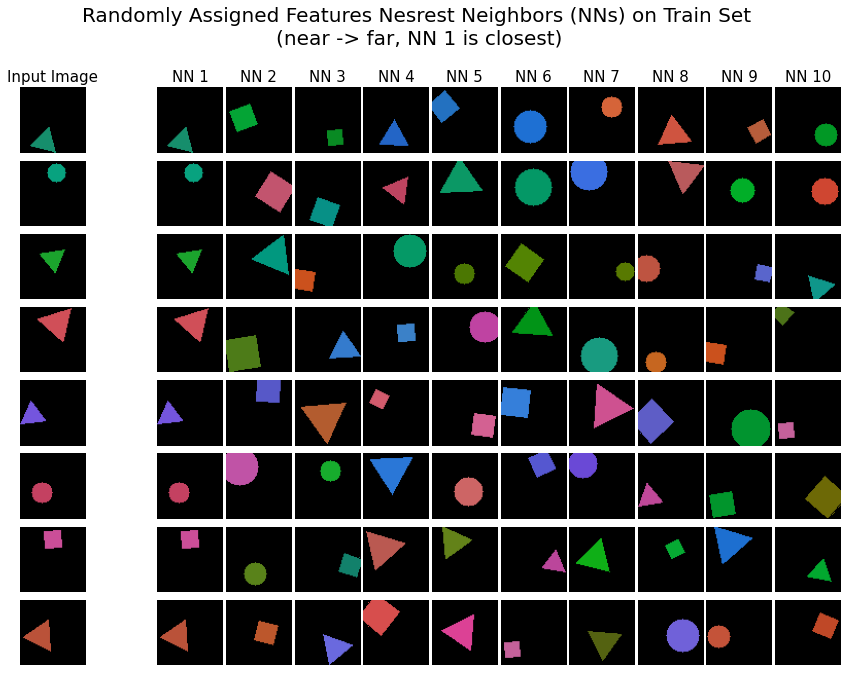

In [ ]:
nn_visualize(
    dataset=Dataset('train'), 
    encoder=lambda batch: torch.randn(batch.shape[0], 128, device=device), 
    desc='Randomly Assigned Features',
)

# Train an Autoencoder

In [ ]:
def train_autoencoder(latent_dim: int):
    r'''
    Train encoder and decoder networks with `latent_dim` latent dimensions according
    to the autoencoder objective (i.e., MSE reconstruction).

    Returns the trained encoder and decoder.
    '''
    enc = Encoder(latent_dim).to(device)
    dec = Decoder(latent_dim).to(device)
        
    optim = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=2e-4)

    dataset = Dataset('train')
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=True)
    num_epochs = 30
    
    loss_crt = nn.MSELoss()
    for epoch in tqdm(range(num_epochs), desc=f'{num_epochs} epochs total'):
        for batch, in dataloader:
            batch = batch.to(device)
            # batch: a batched image tensor of shape [B x 3 x 64 x 64]

            loss = loss_crt(dec(enc(batch)), batch)/batch.shape[0]

            optim.zero_grad()
            loss.backward()
            optim.step()
        print(f'[Autoencoder] epoch {epoch: 4d}   loss = {loss.item():.4g}')
        
    return enc, dec

In [ ]:
ae_enc, ae_dec = train_autoencoder(128)

30 epochs total:   0%|          | 0/30 [00:00<?, ?it/s]

[Autoencoder] epoch    0   loss = 0.00192
[Autoencoder] epoch    1   loss = 0.0009685
[Autoencoder] epoch    2   loss = 0.0007188
[Autoencoder] epoch    3   loss = 0.0006829
[Autoencoder] epoch    4   loss = 0.0007436
[Autoencoder] epoch    5   loss = 0.0006961
[Autoencoder] epoch    6   loss = 0.00069
[Autoencoder] epoch    7   loss = 0.0005379
[Autoencoder] epoch    8   loss = 0.0004621
[Autoencoder] epoch    9   loss = 0.0003359
[Autoencoder] epoch   10   loss = 0.0003496
[Autoencoder] epoch   11   loss = 0.0003408
[Autoencoder] epoch   12   loss = 0.0002988
[Autoencoder] epoch   13   loss = 0.0002987
[Autoencoder] epoch   14   loss = 0.0002367
[Autoencoder] epoch   15   loss = 0.0002249
[Autoencoder] epoch   16   loss = 0.0002156
[Autoencoder] epoch   17   loss = 0.0002337
[Autoencoder] epoch   18   loss = 0.0002158
[Autoencoder] epoch   19   loss = 0.0001977
[Autoencoder] epoch   20   loss = 0.0001952
[Autoencoder] epoch   21   loss = 0.0001912
[Autoencoder] epoch   22   loss = 0.

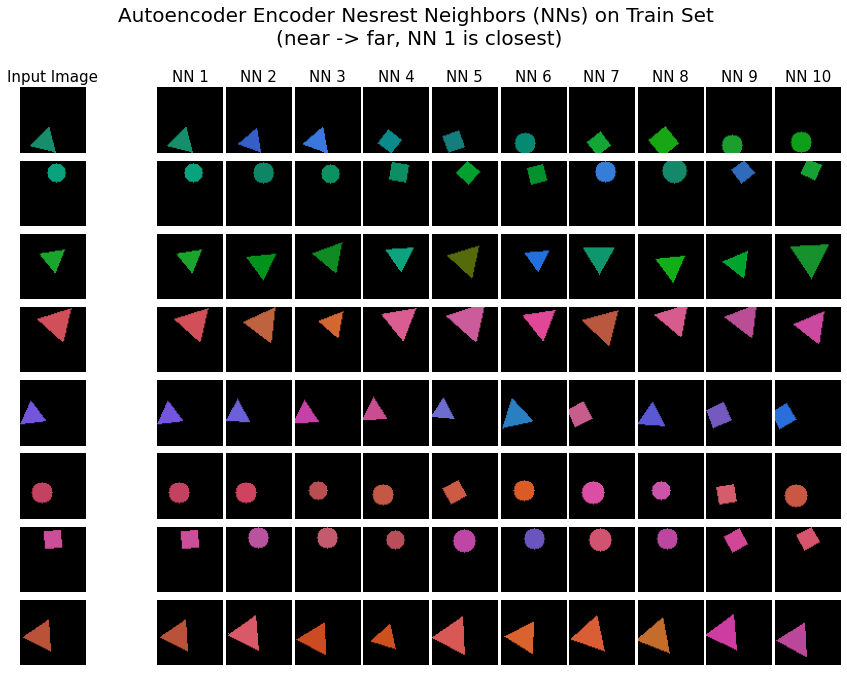

In [ ]:
fig = nn_visualize(Dataset('train'), ae_enc, desc='Autoencoder Encoder')

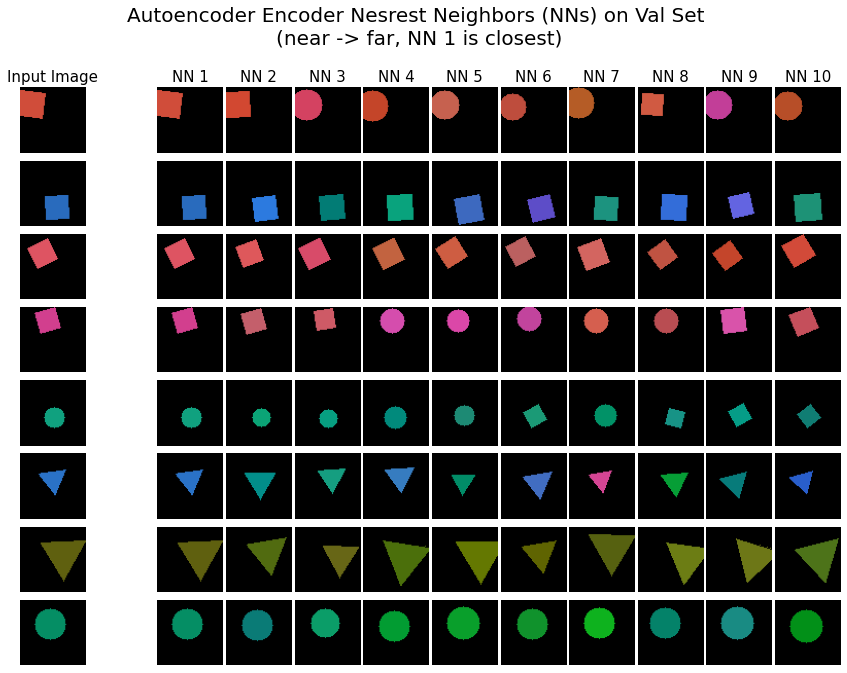

In [ ]:
fig = nn_visualize(Dataset('val'), ae_enc, desc='Autoencoder Encoder')

# Contrastive Learning

Implement the following cross-entroy contrastive loss:

$$\mathcal{L}_\mathsf{contr}(f; \tau) = \mathbb{E}_{\substack{(x, x^+) \sim p_{\mathsf{positive}} \\(y^{\_}_1, \dots, y^{\_}_K) \overset{iid}{\sim} \mathsf{dataset}}}\bigg[ %
    - \log \frac{e^{f(x)^T f(x^+) / \tau}}{e^{f(x)^T f(x^+) / \tau} + \sum_{k=1}^K e^{f(x)^T f(y^-_k) / \tau}}%
\bigg],\qquad f\colon \mathsf{data} → \mathbb{S}^{d-1},\qquad \tau > 0.$$

Notable things about implementation:
1. Encoder $f$ is required to output $l_2$-normalized feature vectors. To implement this, we set the `normalize=True` flag in `Encoder`.
2. $\tau$ is a (fixed) temperature hyperparameter. In our code, we set it to 0.07, which is a common choice. (Usually $\tau \in [0.05, 0.3]$.)
3. As common in image contrastive learning, the positive pairs $p_\mathsf{positive}$ are defined as two random transformed versions of the **same** underlying data sample, where the negative samples are random transforms of **different** data samples. This is implemented by using random augmentations in the `transform=` argument of `Dataset`.
3. To efficiently sample features of negative pairs, we do not independently sample negatives for each positive pair. Instead, we only fetch a batch of positive pairs:

  $$\mathbf{x} \textsf{ of shape } [\underbrace{b}_{{\textsf{batch size}}} \times \underbrace{3 \times 64 \times 64}_{\textsf{image sample shape}}]$$
  $$\mathbf{x}^+ \textsf{ of shape } [b \times 3 \times 64 \times 64],$$

  where for each $\mathbf{x}[i]$, 
  + $(\mathbf{x}[i], \mathbf{x}^+[i])$ forms **the** positive pair <br/>
     (i.e., two random augmentations of the same underlying image). 
  + For $j \neq i$, $(\mathbf{x}[i], \mathbf{x}^+[j])$ form the $\mathbf{(b-1)}$ negative pairs.


  This means that, for encoded latents $$f(\mathbf{x}) \in \mathbb{R}^{b \times d_z} \text{ and } f(\mathbf{x}^+) \in \mathbb{R}^{b \times d_z},$$
  the logits (i.e., pairwise dot products) can be efficiently computed using a single matrix multiplication.

In [ ]:
def train_contrastive(transforms: List, latent_dim: int, *, tau: float = 0.07):
    r'''
    Train encoder with `latent_dim` latent dimensions according
    to the **contrastive** objective described above using temperature
    `tau`.
    
    Implementation should follow notes above (including negative sampling
    from batch).

    The postive pairs are generated using random augmentations 
    specified in `transform`.

    Returns the trained encoder.
    '''

    enc = Encoder(latent_dim, normalize=True).to(device)
        
    optim = torch.optim.Adam(enc.parameters(), lr=2e-4)

    dataset = Dataset('train', torchvision.transforms.Compose(transforms), num_samples=2)
    print('Visualize dataset')
    display.display(dataset.visualize(1, 10)); plt.close('all')
    display.display(dataset.visualize(2, 10)); plt.close('all')
    display.display(dataset.visualize(4, 10)); plt.close('all')
    display.display(dataset.visualize(5, 10)); plt.close('all')
    display.display(dataset.visualize(12, 10)); plt.close('all')
    display.display(dataset.visualize(15, 10)); plt.close('all')

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=True)
    num_epochs = 15

    for epoch in range(num_epochs):
        for batch1, batch2 in tqdm(dataloader, desc=f'Epoch {epoch} / {num_epochs}'):
            batch1 = batch1.to(device)
            batch2 = batch2.to(device)
            # batch1: a batched image tensor of shape [B x 3 x 64 x 64]
            # batch2: a batched image tensor of shape [B x 3 x 64 x 64]

            # For each i, p
            #   Positive pairs are (batch1[i], batch2[i])
            #   Negative pairs are (batch1[i], batch2[j]), j != i.

            loss = 0.0
            Enc1,Enc2 = enc(batch1), enc(batch2)
            for i in range(batch1.shape[0]):
              loss += - torch.log(torch.exp(torch.matmul(Enc1[i], Enc2[i]) / tau) / torch.sum(torch.exp(torch.matmul(Enc1[i].T, Enc2.T) / tau)) )              
            loss /= batch1.shape[0]
            
            optim.zero_grad()
            loss.backward()
            optim.step()
        print(f'[Contrastive] epoch {epoch: 4d}   loss = {loss.item():.4g}')
        
    return enc

In [ ]:
b


0

## Augmentation A

Visualize augmentation A


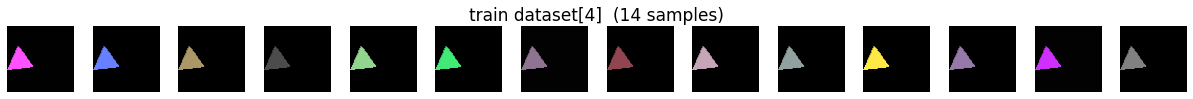

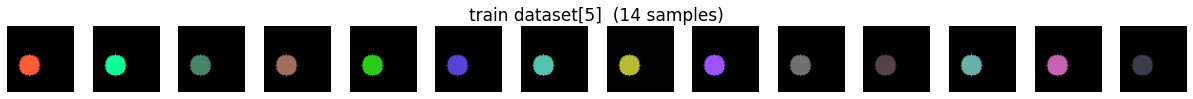

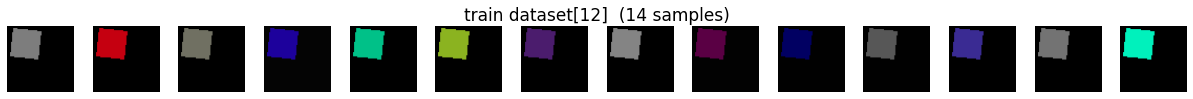

In [ ]:
aug_A = [
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.ColorJitter(hue=.5, brightness=0.3, contrast=0.3, saturation=0.9),
]

dataset = Dataset('train', torchvision.transforms.Compose(aug_A), num_samples=2)
print('Visualize augmentation A')
for idx in [4, 5, 12]:
    _ = dataset.visualize(idx, 14)

## Augmentation B

Visualize augmentation B


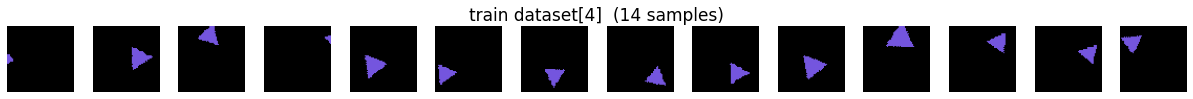

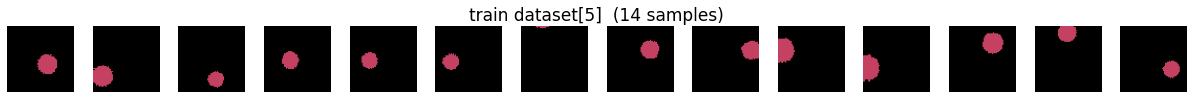

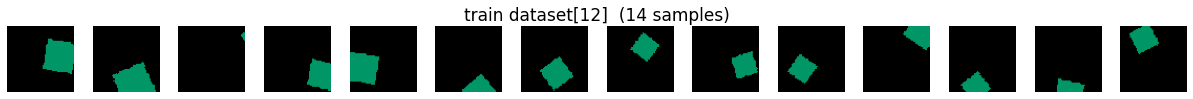

In [ ]:
interpolation = torchvision.transforms.InterpolationMode.NEAREST
aug_B = [
    torchvision.transforms.Pad(24),
    torchvision.transforms.RandomRotation(degrees=(0, 360)),
    torchvision.transforms.RandomResizedCrop([64, 64], scale=(0.2, 0.6), ratio=(1, 1), interpolation=interpolation),
]


dataset = Dataset('train', torchvision.transforms.Compose(aug_B), num_samples=2)
print('Visualize augmentation B')
for idx in [4, 5, 12]:
    _ = dataset.visualize(idx, 14)

## Augmentation C

Visualize augmentation C


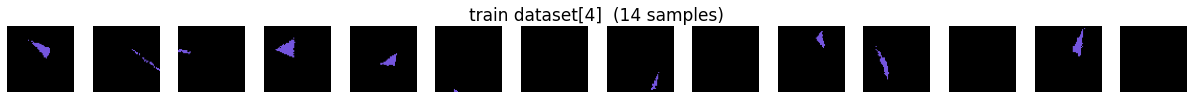

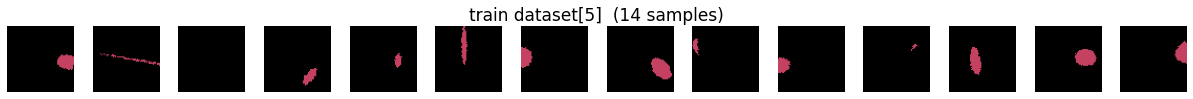

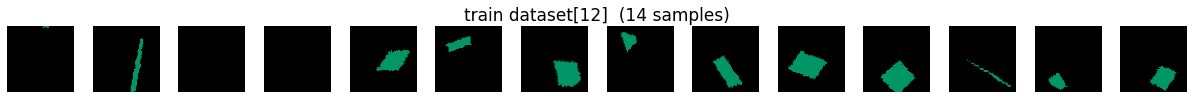

In [ ]:
interpolation = torchvision.transforms.InterpolationMode.NEAREST
aug_C = [
    torchvision.transforms.Pad(16),
    torchvision.transforms.RandomRotation(degrees=(0, 360)),
    torchvision.transforms.RandomApply(
        [
            torchvision.transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), shear=(-80, 80, -80, 80), interpolation=interpolation),
            torchvision.transforms.RandomPerspective(distortion_scale=0.6,  p=1, interpolation=interpolation),
        ],
        p=0.7,
    ),
    torchvision.transforms.RandomResizedCrop([64, 64], scale=(0.4, 0.8), ratio=(0.2, 5), interpolation=interpolation),
    torchvision.transforms.RandomRotation(degrees=(0, 360)),
]


dataset = Dataset('train', torchvision.transforms.Compose(aug_C), num_samples=2)
print('Visualize augmentation C')
for idx in [4, 5, 12]:
    _ = dataset.visualize(idx, 14)

## Train Encoders



Visualize dataset


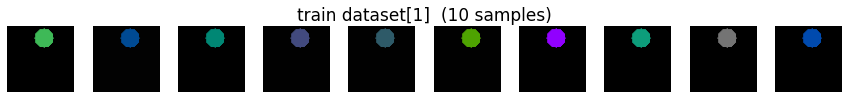

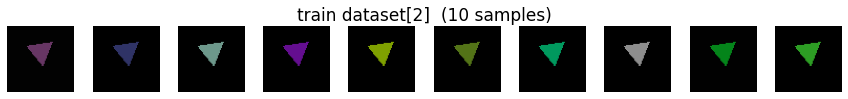

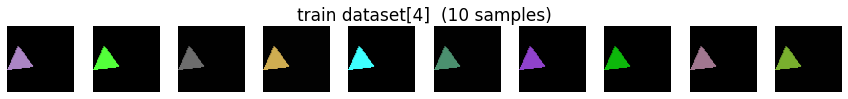

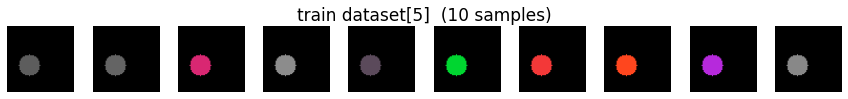

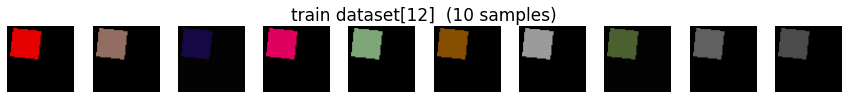

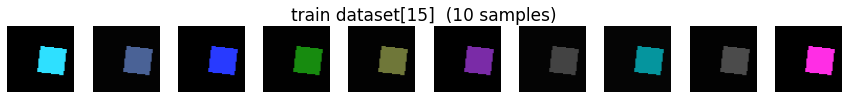

Epoch 0 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    0   loss = 3.455


Epoch 1 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    1   loss = 2.057


Epoch 2 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    2   loss = 0.6714


Epoch 3 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    3   loss = 1.215


Epoch 4 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    4   loss = 0.1759


Epoch 5 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    5   loss = 0.5025


Epoch 6 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    6   loss = 1.21


Epoch 7 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    7   loss = 0.2053


Epoch 8 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    8   loss = 1.751


Epoch 9 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    9   loss = 0.4827


Epoch 10 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   10   loss = 0.2214


Epoch 11 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   11   loss = 0.1024


Epoch 12 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   12   loss = 0.1023


Epoch 13 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   13   loss = 0.8243


Epoch 14 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   14   loss = 0.4835


In [ ]:


contrastive_enc_aug_A = train_contrastive(transforms=aug_A, latent_dim=128)

Visualize dataset


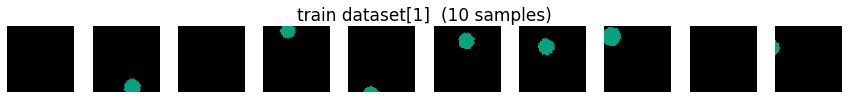

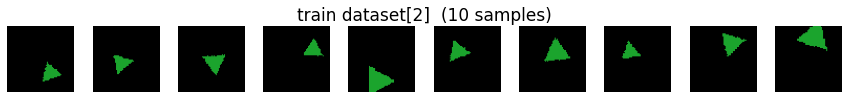

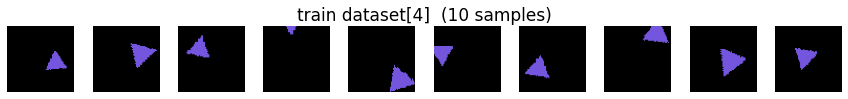

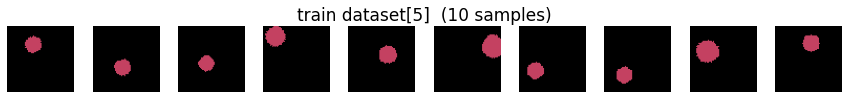

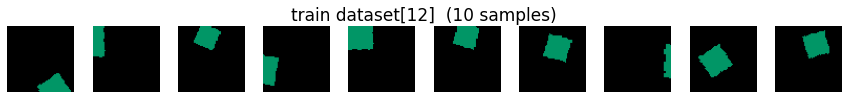

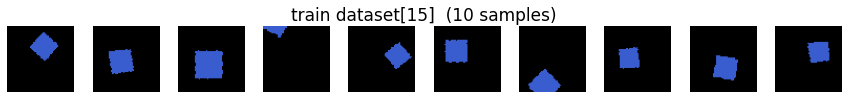

Epoch 0 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)


[Contrastive] epoch    0   loss = 178


Epoch 1 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    1   loss = 97.13


Epoch 2 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    2   loss = 95.15


Epoch 3 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    3   loss = 91.61


Epoch 4 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    4   loss = 57.99


Epoch 5 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    5   loss = 95.93


Epoch 6 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    6   loss = 54.95


Epoch 7 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    7   loss = 54.12


Epoch 8 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    8   loss = 63.71


Epoch 9 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    9   loss = 92.47


Epoch 10 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   10   loss = 48.37


Epoch 11 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   11   loss = 55.13


Epoch 12 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   12   loss = 37.38


Epoch 13 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   13   loss = 36.32


Epoch 14 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   14   loss = 38.44


In [ ]:


contrastive_enc_aug_B = train_contrastive(transforms=aug_B, latent_dim=128)

Visualize dataset


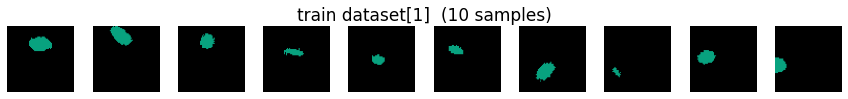

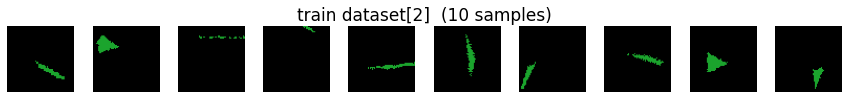

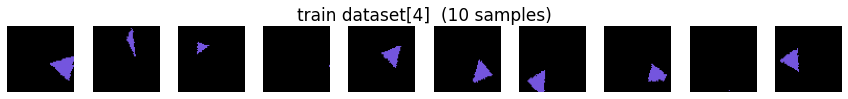

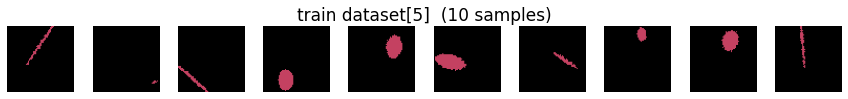

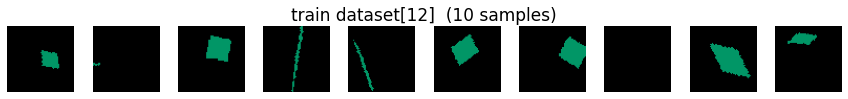

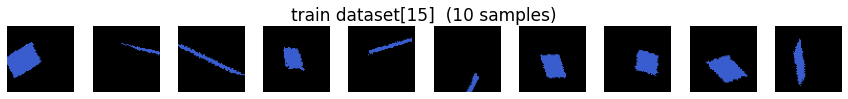

Epoch 0 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    0   loss = 2.787


Epoch 1 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    1   loss = 2.038


Epoch 2 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    2   loss = 2.333


Epoch 3 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    3   loss = 1.852


Epoch 4 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    4   loss = 1.761


Epoch 5 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    5   loss = 1.278


Epoch 6 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    6   loss = 1.257


Epoch 7 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    7   loss = 1.421


Epoch 8 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    8   loss = 1.712


Epoch 9 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch    9   loss = 1.621


Epoch 10 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   10   loss = 1.552


Epoch 11 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   11   loss = 1.328


Epoch 12 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   12   loss = 1.705


Epoch 13 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   13   loss = 1.576


Epoch 14 / 15:   0%|          | 0/157 [00:00<?, ?it/s]

[Contrastive] epoch   14   loss = 1.344


In [ ]:


contrastive_enc_aug_C = train_contrastive(transforms=aug_C, latent_dim=128)

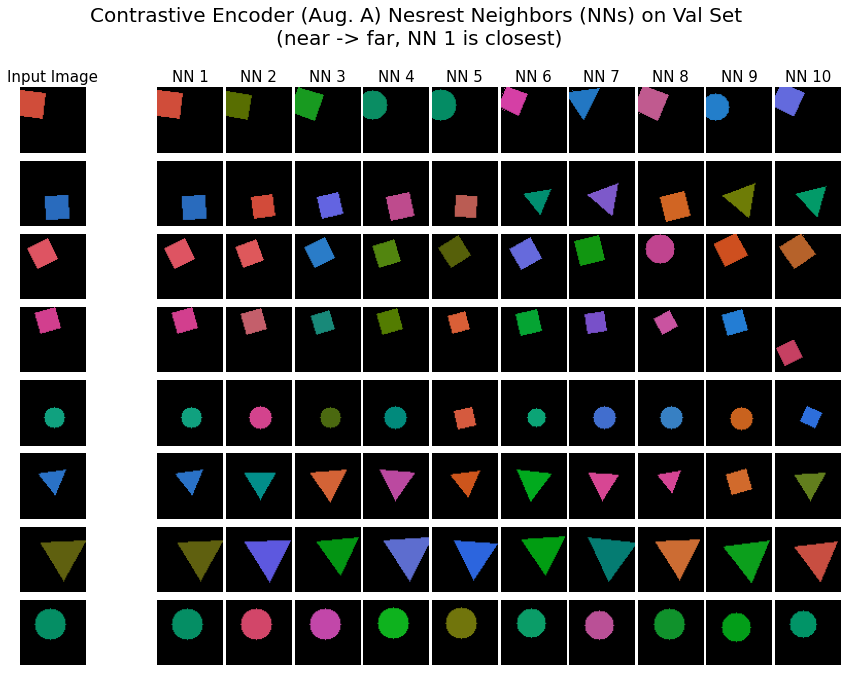

In [ ]:
_ = nn_visualize(Dataset('val'), contrastive_enc_aug_A, desc='Contrastive Encoder (Aug. A)')

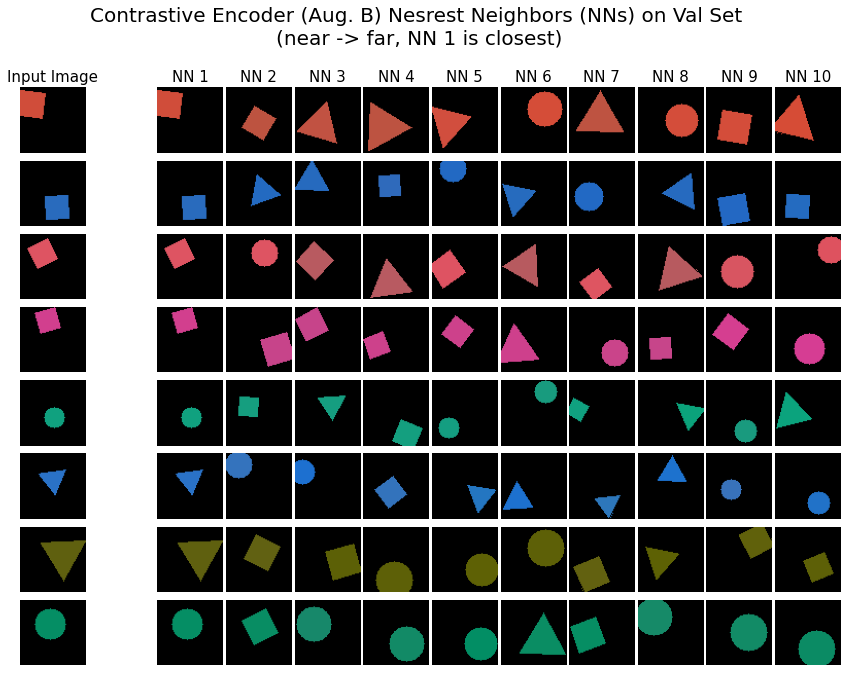

In [ ]:
_ = nn_visualize(Dataset('val'), contrastive_enc_aug_B, desc='Contrastive Encoder (Aug. B)')

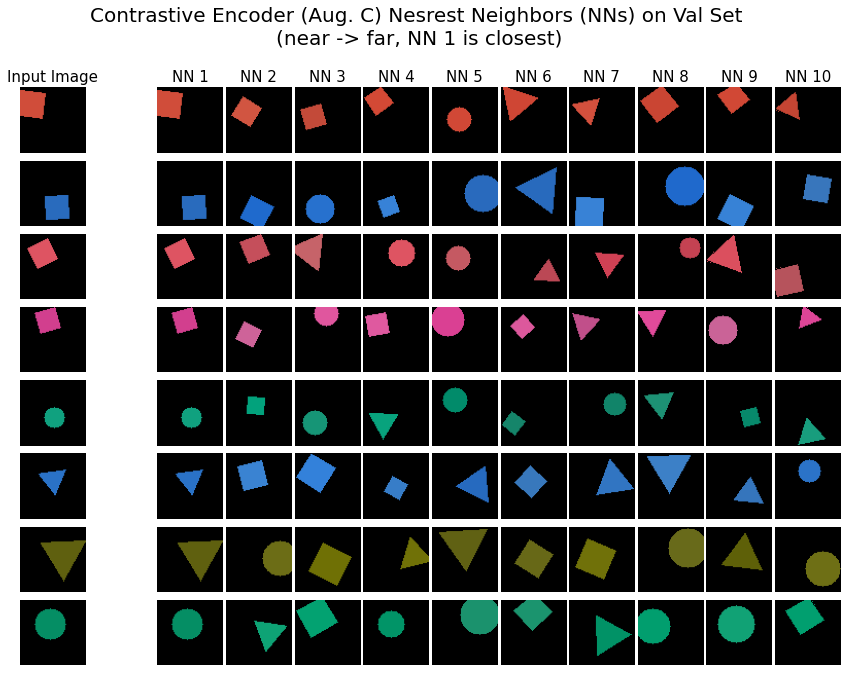

In [ ]:
_ = nn_visualize(Dataset('val'), contrastive_enc_aug_C, desc='Contrastive Encoder (Aug. C)')